In [0]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, LSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D, Conv2D, MaxPooling2D
from keras.constraints import max_norm

from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords                
from nltk.stem.snowball import RussianStemmer
from scipy.stats import boxcox
import re
#from tqdm import tqdm

E:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Check GPU Availability

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 769344123011150676
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3174131302
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4188723035968858966
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

### Preprocess Training and Testing Data

* > train.csv, test.csv, train_jpg.zip, test_jpg.zip: Download from kaggle competition website
* > aggregated_features, self trained wordvec: https://drive.google.com/drive/folders/1yO_W-m0fF_PludrnScdgyTGsPFoDsA6_?usp=sharing

In [0]:
agg_features_path = 'aggregated_features.csv'
train_data_path = 'train.csv'
test_data_path = 'test.csv'
train_img_path = 'train_jpg/data/competition_files/train_jpg/'
test_img_path = 'test_jpg/data/competition_files/test_jpg/'

seed = 411
rnn_train_epochs = 8
batch_size=64 # 32 or 64 is good (too huge for my PC), 128 is worse in the past experiments
cpu_count=3

In [0]:
agg_features = pd.read_csv(agg_features_path)
agg_cols = list(agg_features.columns)[1:]

In [0]:
train = pd.read_csv('train.csv', parse_dates=['activation_date']) \
          .sort_values('activation_date') \
          .reset_index(drop=True)
    
test = pd.read_csv('test.csv', parse_dates=['activation_date'])

In [0]:
train = train.merge(agg_features, on='user_id', how='left')
test = test.merge(agg_features, on='user_id', how='left')
del agg_features; gc.collect()

86

In [0]:
# merge to faciliate data cleaning and transformation
train_len = train.shape[0]
train_y = train.deal_probability.values

train.drop('deal_probability', axis=1, inplace=True)

In [0]:
# merge adv features
import pickle
adv_features = pickle.load(open('filtered_rnn_merge_features.pkl', 'rb'))

train = pd.concat([train, adv_features['train']], axis=1)
test = pd.concat([test, adv_features['test']], axis=1)

adv_categorical = adv_features['categorical']
adv_numerical = [col for col in adv_features['train'].columns if col not in adv_categorical]

del adv_features; gc.collect()

14

In [0]:
all_features = pd.concat([train, test]).reset_index(drop=True)
del train, test; gc.collect()

0

#### Clean data

In [0]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [0]:
stemmer = RussianStemmer(ignore_stopwords=False)
'''
def clean_text(txt):
    words = str(txt).lower().strip().split(" \t\r.,!?^+-*/@~:;/\\\"\'&{}[]()#$%") #str(txt).split(" ") #
    words = [stemmer.stem(wrd) for wrd in words \
                if wrd not in stopwords.words('russian') and len(wrd) > 1]
    txt = u" ".join(words)
    return txt
'''
def clean_text(txt):
    return u" ".join([stemmer.stem(re.sub(r'\b\d+\b', '', wrd)) for wrd in str(txt).lower().strip().split(string.punctuation)
                         if wrd not in stopwords.words('russian')])

In [0]:
all_features['description'].fillna('unknowndescription', inplace=True)
#all_features['description'] = [clean_text(txt) for txt in all_features['description'].values] # clean text

all_features['title'].fillna('unknowntitle', inplace=True)
#all_features['title'] = [clean_text(txt) for txt in all_features['title'].values]

all_features['weekday'] = pd.to_datetime(all_features['activation_date']).dt.day

for col in ['description', 'title']:
    all_features['num_words_' + col] = all_features[col].apply(lambda comment: len(comment.split()))
    all_features['num_unique_words_' + col] = all_features[col].apply(lambda comment: len(set(w for w in comment.split())))

all_features['words_vs_unique_title'] = all_features['num_unique_words_title'] / all_features['num_words_title'] * 100
all_features['words_vs_unique_description'] = all_features['num_unique_words_description'] / all_features['num_words_description'] * 100
all_features['words_vs_unique_description'] = all_features['words_vs_unique_description'].fillna(0.)

all_features['city'] = all_features['region'] + '_' + all_features['city'] # city is repeated in different region
all_features['num_desc_punct'] = all_features['description'].apply(lambda x: count(x, set(string.punctuation)))

for col in agg_cols:
    all_features[col].fillna(-1, inplace=True)

for col in ['price', 'image_top_1']:
    all_features[col].fillna(-1, inplace=True)

for col in ['param_1', 'param_2', 'param_3']:
    all_features[col].fillna('unknwonparam', inplace=True)
    
for col in ['image']:
    all_features[col].fillna('no-image', inplace=True)

In [0]:
# merge transfer image features from vgg16

df = pd.read_pickle('vgg16_image_pca_feature.csv_pkl')
image_features = df.columns.tolist()[1:] # column 0 is 'image' 

all_features = all_features.merge(df, on='image', how='left')
del df; gc.collect()

35

In [0]:
all_features.isnull().sum()

item_id                                  0
user_id                                  0
region                                   0
city                                     0
parent_category_name                     0
category_name                            0
param_1                                  0
param_2                                  0
param_3                                  0
title                                    0
description                              0
price                                    0
item_seq_number                          0
activation_date                          0
user_type                                0
image                                    0
image_top_1                              0
avg_days_up_user                         0
avg_times_up_user                        0
med_days_up_user                         0
med_times_up_user                        0
n_user_items                             0
price_pred                               0
price_pred_

#### Transform data

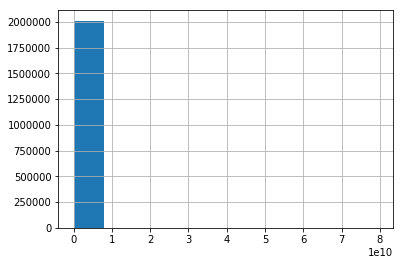

In [0]:
all_features.price.hist()

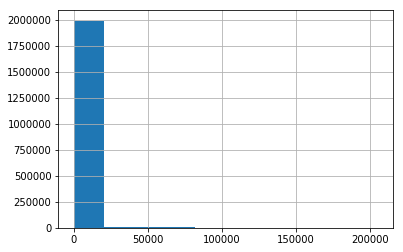

In [0]:
all_features.item_seq_number.hist()

> Since price and item seq number are highly skewed, we'll transform it into more normal like by using boxcox (more robust to outliers compared to np.log1p)

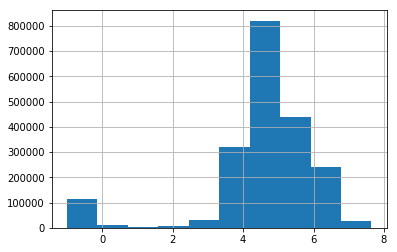

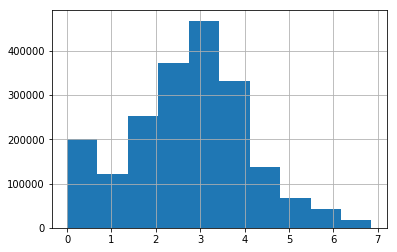

In [0]:
for col in ['price', 'item_seq_number']:
    select_filter = all_features[col] > 0
    all_features.loc[select_filter, col], _ = boxcox(all_features.loc[select_filter, col])
    all_features[col].hist()
    plt.show()

In [0]:
all_features.columns.tolist()

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'avg_days_up_user',
 'avg_times_up_user',
 'med_days_up_user',
 'med_times_up_user',
 'n_user_items',
 'price_pred',
 'price_pred_onlydescription',
 'price_pred_all',
 'ga',
 'image_top_1_mean_price_pred',
 'image_top_1_std_price_pred',
 'image_top_1_mean_item_seq_number',
 'latitude',
 'longitude',
 'lat_lon_hdbscan_cluster_05_03',
 'lat_lon_hdbscan_cluster_10_03',
 'lat_lon_hdbscan_cluster_20_03',
 'img_size',
 'height',
 'width',
 'nasnet_nima_med',
 'nasnet_nima_std',
 'nasnet_nima_max',
 'nasnet_nima_min',
 'active_price_pred',
 'active_duration_pred',
 'active_ad_count_pred',
 'weekday',
 'num_words_description',
 'num_unique_words_description',
 'num_words_title',
 'num_unique_words_title',
 'words_vs_unique_title',
 'words_vs_unique_descripti

In [0]:
target = 'deal_probability'
numerical = [
    'weekday', 'num_words_title', 'num_words_description',
    'num_unique_words_title', 'num_unique_words_description',
    'words_vs_unique_title', 'words_vs_unique_description',
    'num_desc_punct', 'avg_times_up_user', 'avg_days_up_user', 
    'med_times_up_user', 'med_days_up_user', 'n_user_items', 
    'price', 'item_seq_number'
]

categorical = [
    'image_top_1', 'param_1', 'param_2', 'param_3', 
    'city', 'region', 'category_name', 'parent_category_name', 'user_type'
]

In [0]:
# label encode categorical data
from sklearn.preprocessing import LabelEncoder

for feature in categorical:
    print('Transforming {}...'.format(feature))
    encoder = LabelEncoder()
    all_features.loc[:, feature] = encoder.fit_transform(all_features[feature].astype(str))

Transforming image_top_1...
Transforming param_1...
Transforming param_2...
Transforming param_3...
Transforming city...
Transforming region...
Transforming category_name...
Transforming parent_category_name...
Transforming user_type...


In [0]:
all_features.loc[:, numerical] = all_features[numerical].fillna(-1)

for img_feat in image_features:
    print(all_features[img_feat].mean())
    all_features.loc[:, img_feat] = all_features[img_feat].fillna(all_features[img_feat].mean())

0.0013509846
0.015712447
0.017517015
-0.0063661863
-0.0013172567
0.006105601
0.0037530398
0.0014948485
0.0032237202
-0.00066073803
0.0007887319
0.0022926135
-0.002191485
0.0053395396
-0.0015907068
-0.0019864922
-0.004096582
0.0047213417
-0.0024236594
-9.9437406e-05
0.00049136096
0.0008045598
0.0014091776
0.0005847732
-0.0005037055
0.0019050244
-0.0020543425
-0.002147264
0.00046229392
0.0010288277


In [0]:
all_features[numerical].isnull().sum()

weekday                         0
num_words_title                 0
num_words_description           0
num_unique_words_title          0
num_unique_words_description    0
words_vs_unique_title           0
words_vs_unique_description     0
num_desc_punct                  0
avg_times_up_user               0
avg_days_up_user                0
med_times_up_user               0
med_days_up_user                0
n_user_items                    0
price                           0
item_seq_number                 0
dtype: int64

In [0]:
# standardize numerical data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_features.loc[:, numerical] = scaler.fit_transform(all_features[numerical].values)

In [0]:
numerical = numerical + adv_numerical
categorical = categorical + adv_categorical
features = numerical+categorical+image_features

#### Prepare  pre-trained embeddings and text

In [0]:
max_features = 500000
maxlen = 150
embed_size = 300

title_max_features = 200000
title_maxlen = 80
title_embed_size = 100

In [0]:
embed_info = pickle.load(open('rnn_embed.pkl', 'rb'))
embed_info.keys()

dict_keys(['desc_embed_info', 'title_embed_info'])

In [0]:
desc_embed_info = embed_info['desc_embed_info']
title_embed_info = embed_info['title_embed_info']

In [0]:
print('setup max info for embedding in categorical variables')
max_info = dict((col, all_features[col].max()+1) for col in categorical)

setup max info for embedding in categorical variables


### Build RNN Model

In [0]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [0]:
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        print(input_shape)
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
def clip_rmse(true, prediction):
    return np.sqrt(metrics.mean_squared_error(true, np.clip(prediction, 0., 1.)))
    
class NBatchEvalLogger(Callback):
    def __init__(self, display, val_X, val_y, save_path=None, save_start=1000):
        self.step = 0
        self.display = display
        self.val_X = val_X
        self.val_y = val_y
        self.best_loss = None
        self.save_path = save_path
        self.save_start = save_start
        self.record_count = 0
        
    def on_batch_end(self, batch, logs={}):
        self.step += 1
        if self.step % self.display == 0 and self.step >= self.save_start:
            #loss, metric = self.model.evaluate(self.val_X, self.val_y, batch_size=128, verbose=1)
            prediction = self.model.predict(self.val_X, batch_size=128, verbose=0)
            loss = clip_rmse(self.val_y, prediction)
            
            if self.best_loss is None:
                self.best_loss = loss
            else:
                if loss < self.best_loss:
                    self.best_loss = loss
                    if self.save_path is not None:
                        self.model.save(self.save_path, overwrite=True)
                        self.record_count += 1
                    
            print('\rstep: {} val loss={:.5f}, best loss={:.5f}'.format(self.step, loss, self.best_loss))

In [0]:
import keras
from copy import deepcopy as cp
import os
from zipfile import ZipFile
import cv2
import numpy as np
import pandas as pd
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input
import concurrent.futures
from multiprocessing.pool import ThreadPool

class DataGenerator(keras.utils.Sequence):
    #'Generates data for Keras'
    def __init__(self, list_IDs, X, y, img_path, batch_size=32, shuffle=True, is_train=True):
        #'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.img_path = img_path
        self.is_train = is_train
        self.on_epoch_end()
        #self.zipped = ZipFile(img_arch)
        #print('file names:\n', self.zipped.namelist()[1:10], '\n...')
        
        global cpu_count
        self.pool = ThreadPool(cpu_count)
    
    def __len__(self):
        #'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        #'Generate one batch of data'
        # Generate indexes of the batch
        start = index*self.batch_size
        end = min((index+1)*self.batch_size, len(self.indexes))
        indexes = self.indexes[start: end]

        # Generate data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        #'Updates indexes after each epoch'
        self.indexes = cp(list(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def load_img_from_zipped(self, param):
        
        img_id, i, imgs_holder = param[0], param[1], param[2]
        invalid_img_ids = ['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c', 
                           '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58', 
                           '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83', 
                           'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']
        try:
            if img_id in invalid_img_ids or img_id == 'no-image':
                pass
            else:
                imz = cv2.imread(self.img_path+img_id+'.jpg')
                imz = cv2.resize(imz, (224,224), interpolation=cv2.INTER_AREA)
                imgs_holder[i] = img_to_array(imz)
        except:
            print(img_id, ' is invalid')
            pass
            
        return None
    
    def parallel_load_imgs(self, img_ids, wait=True):
     
        imgs_holder = np.zeros((len(img_ids), 224, 224, 3))
        
        '''
        for i, im_id in enumerate(img_ids):
            self.load_img_from_zipped(im_id, i, imgs_holder)
          
        self.res = [self.pool.apply_async(self.load_img_from_zipped, (im_id, i, imgs_holder)) for i, im_id in enumerate(img_ids)]
        if wait:
            for r in self.res:
                r.get()
        '''   
        for x in self.pool.imap_unordered(self.load_img_from_zipped, [(im_id, i, imgs_holder) for i, im_id in enumerate(img_ids)], 
                                 chunksize=batch_size//cpu_count):
            pass
        
        #print(imgs_holder)
        imgs_holder = preprocess_input(imgs_holder) # adjust to mean of rgb to some value
        
        return imgs_holder
    
    def __data_generation(self, list_IDs_temp):
        #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Generate data
        X = dict((col, self.X.loc[list_IDs_temp, col].values) for col in features)
        X['desc'] = desc_embed_info['text'][list_IDs_temp,:]
        X['title'] = title_embed_info['text'][list_IDs_temp,:]
        #X['imgs'] = self.X.loc[list_IDs_temp, image_features].values
        #self.parallel_load_imgs(self.X.loc[list_IDs_temp, 'image'].values)
        
        if self.is_train:
            y = cp(self.y[list_IDs_temp])
            return X, y
        else:
            return X

In [0]:
# 'train_jpg.zip', 'data/competition_files/train_jpg/', 
# debug use
'''
zipped = ZipFile('train_jpg.zip')
print(zipped.namelist()[1:10])

img_id = '2809fd6afd6d3cae4dd4ad93a7f905a0db32292f4df4b3f19fa5492e08cbfd90'
target_size=(224,224)
try:
    exfile = zipped.read('data/competition_files/train_jpg/'+img_id+'.jpg')
    arr = np.frombuffer(exfile, np.uint8)
    imz = cv2.imdecode(arr, flags=cv2.IMREAD_UNCHANGED)
    imz = cv2.resize(imz, target_size, interpolation=cv2.INTER_AREA)
except:
    print(img_id, ' is invalid')
    imz = None
imz
'''

"\nzipped = ZipFile('train_jpg.zip')\nprint(zipped.namelist()[1:10])\n\nimg_id = '2809fd6afd6d3cae4dd4ad93a7f905a0db32292f4df4b3f19fa5492e08cbfd90'\ntarget_size=(224,224)\ntry:\n    exfile = zipped.read('data/competition_files/train_jpg/'+img_id+'.jpg')\n    arr = np.frombuffer(exfile, np.uint8)\n    imz = cv2.imdecode(arr, flags=cv2.IMREAD_UNCHANGED)\n    imz = cv2.resize(imz, target_size, interpolation=cv2.INTER_AREA)\nexcept:\n    print(img_id, ' is invalid')\n    imz = None\nimz\n"

In [0]:
#cv2.imread('train_jpg/data/competition_files/train_jpg/'+img_id+'.jpg')

In [0]:
def build_model(categorical_features, numerical_features):
    
    # non-cat features
    non_cat_inputs = []
    for col in numerical_features:
        f = Input(shape=[1], name=col)
        non_cat_inputs.append(f)
    
    non_cat_ch = concatenate(non_cat_inputs)
    non_cat_ch = Dense(32, activation='relu')(non_cat_ch)
    
    # cat features
    cat_inputs = []
    cat_embeds = []
    for col in categorical_features:
        f = Input(shape=[1], name=col)
        embed_dim = max_info[col].max()
        if max_info[col] > 10:
            reduced_dim = 10
        else:
            reduced_dim = 1
        embed_f = Embedding(embed_dim, reduced_dim)(f)
        flatten_f = Flatten()(embed_f)
        cat_inputs.append(f)
        cat_embeds.append(flatten_f)
    
    cat_ch = concatenate(cat_embeds)
    cat_ch = Dense(64, activation='relu')(cat_ch)
        
    # text features: architecture of text to try here!!!
    
    # description
    text_inp = Input(shape = (maxlen, ), name='desc')
    text_emb = Embedding(desc_embed_info['nb_words'], embed_size, weights = [desc_embed_info['emb_matrix']],
                    input_length = maxlen, trainable = False)(text_inp)
    text_emb = SpatialDropout1D(0.3)(text_emb)
    text_gru = Bidirectional(CuDNNGRU(128, return_sequences = True))(text_emb)
    text_gru = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(text_gru)
    text_gru_avg = GlobalAveragePooling1D()(text_gru)
    text_gru_max = GlobalMaxPooling1D()(text_gru)
    text_gru = concatenate([text_gru_avg, text_gru_max]) 
    text_gru = Dropout(0.1)(text_gru)
    
    # title
    title_inp = Input(shape = (title_maxlen, ), name='title')
    title_emb = Embedding(title_embed_info['nb_words'], title_embed_size, weights = [title_embed_info['emb_matrix']],
                    input_length = title_maxlen, trainable = False)(title_inp)
    title_emb = SpatialDropout1D(0.1)(title_emb)
    title_gru = Bidirectional(CuDNNGRU(32, return_sequences = True))(title_emb)
    title_gru = Conv1D(16, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(title_gru)
    title_gru_avg = GlobalAveragePooling1D()(title_gru)
    title_gru_max = GlobalMaxPooling1D()(title_gru)
    title_gru = concatenate([title_gru_avg, title_gru_max]) 
    title_gru = Dropout(0.1)(title_gru)
    
    text_ch = concatenate([text_gru, title_gru])
    text_ch = Dense(64, activation='relu')(text_ch)
    
    # add image architecture
    # reference: https://keras.io/getting-started/functional-api-guide/#more-examples, Visual question answering model
    
    '''
    img_inp = Input(shape = (224, 224, 3 ), name='imgs')
    img_ch = Conv2D(64, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_inp)
    img_ch = Conv2D(64, (3, 3), activation='relu')(img_ch)
    img_ch = MaxPooling2D((2, 2))(img_ch)
    #img_ch = Conv2D(128, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_ch)
    #img_ch = Conv2D(128, (3, 3), activation='relu')(img_ch)
    #img_ch = MaxPooling2D((2, 2))(img_ch)
    #img_ch = Conv2D(256, (3, 3), activation='relu', padding='same', W_constraint=max_norm(3))(img_ch)
    #img_ch = Conv2D(256, (3, 3), activation='relu')(img_ch)
    #img_ch = Conv2D(256, (3, 3), activation='relu')(img_ch)
    #img_ch = MaxPooling2D((2, 2))(img_ch)
    img_ch = Flatten()(img_ch)
    img_ch = Dense(64, activation='relu')(img_ch)
    '''
    img_inputs = []
    for col in image_features:
        f = Input(shape=[1], name=col)
        img_inputs.append(f)
    
    img_ch = concatenate(img_inputs)
    img_ch = Dense(32, activation='relu')(img_ch)
    
    # merge each branch: non-cat, cat, text, img
    concat_main = [non_cat_ch, cat_ch, text_ch, img_ch]
    main = concatenate(concat_main)
    main = BatchNormalization()(main)
    main = Dropout(0.1)(main)
    main = BatchNormalization()(Dense(128, activation='relu')(main))
    out = Dense(1, activation = "sigmoid")(main)

    concat_input = non_cat_inputs+cat_inputs+img_inputs+[text_inp, title_inp]
    model = Model(concat_input, out)
    model.regularizers = [regularizers.l2(0.0001)]
    model.compile(optimizer = Adam(lr=0.001), loss = root_mean_squared_error,
                  metrics =[root_mean_squared_error])
    model.summary()
    return model

### Training

In [0]:
from sklearn.model_selection import KFold
import warnings; warnings.filterwarnings('ignore') 

In [0]:
train_indices = np.arange(0, train_len)
test_indices = np.arange(train_len, all_features.shape[0])

In [0]:
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress

In [0]:
start_fold = 0 # <= 0 for invalid, train from fold 1, > 0: used to train from fold=start_fold
resume_file_prefix = '0625_rnn' # whatever we like

In [0]:
if start_fold > 0:
    import pickle
    ret = pickle.load(open(resume_file_prefix+'_oof_val_pred', 'rb'))
    ret_test = pickle.load(open(resume_file_prefix+'_oof_test_pred', 'rb'))
    print(ret)
    print(ret_test)
else:
    ret = np.zeros((train_len,))
    ret_test = np.zeros((all_features.shape[0]-train_len,))

fold = 0    
for tr_ix, val_ix in KFold(5, shuffle=True, random_state=seed).split(train_indices):
    fold += 1
    
    if start_fold > 0 and fold < start_fold:
        continue
    else:
        pass
    
    model = build_model(categorical, numerical)
    file_path = "rnn_weights/model_self_train_with_image_fold_{}.hdf5".format(fold)
     
    # customized batch loader
    training_generator = DataGenerator(tr_ix, all_features, train_y, train_img_path, 
                                       batch_size=batch_size, shuffle=True)
    validation_generator = DataGenerator(val_ix, all_features, train_y, train_img_path, 
                                         batch_size=batch_size, shuffle=False)

    lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//6)), verbose=1)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    history = model.fit_generator(generator=training_generator,
                                  validation_data=validation_generator,
                                  use_multiprocessing=False,
                                  workers=1, 
                                  epochs=rnn_train_epochs,
                                  verbose = 0, 
                                  callbacks = [lr_schd, check_point, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    
    # Predict val + test oofs
    model.load_weights(file_path) # load weight with best validation score
    
    del validation_generator
    validation_generator = DataGenerator(val_ix, all_features, None, train_img_path, 
                                         batch_size=batch_size, shuffle=False, is_train=False)
    test_generator = DataGenerator(test_indices, all_features, None, test_img_path,       
                                   batch_size=batch_size, shuffle=False, is_train=False)
    
    ret[val_ix] = model.predict_generator(validation_generator, use_multiprocessing=False, workers=1).reshape((len(val_ix),))
    ret_test += model.predict_generator(test_generator, use_multiprocessing=False, workers=1).reshape((ret_test.shape[0],))
    
    del model, history, training_generator, validation_generator, test_generator; gc.collect()
    
ret_test /= 5

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc (InputLayer)               (None, 150)          0                                            
__________________________________________________________________________________________________
title (InputLayer)              (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 150, 300)     150000000   desc[0][0]                       
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 80, 100)     

__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 10)           0           embedding_4[0][0]                
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 10)           0           embedding_5[0][0]                
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 10)           0           embedding_6[0][0]                
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 10)           0           embedding_7[0][0]                
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 1)            0           embedding_8[0][0]                
__________

__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1120        concatenate_1[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           6592        concatenate_2[0][0]              
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           10304       concatenate_5[0][0]              
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           992         concatenate_6[0][0]              
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 192)          0           dense_1[0][0]                    
          


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00001: val_loss improved from inf to 0.21866, saving model to rnn_weights/model_self_train_with_image_fold_1.hdf5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00002: val_loss improved from 0.21866 to 0.21671, saving model to rnn_weights/model_self_train_with_image_fold_1.hdf5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.



Epoch 00003: val_loss improved from 0.21671 to 0.21584, saving model to rnn_weights/model_self_train_with_image_fold_1.hdf5

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.


In [0]:
# uncomment these to dump files if OOM (out-of-mem) happens
import pickle
pickle.dump(ret, open(resume_file_prefix+'_oof_val_pred', 'wb'))
pickle.dump(ret_test, open(resume_file_prefix+'_oof_test_pred', 'wb'))

In [0]:
pd.Series(ret).value_counts()

In [0]:
# public:  cv = .2220, lb = .2247 
# bigru-conv1d: cv =.2185 , lb = .2235
# bigru-attention: cv =.2186 , lb = .2235
# 2gru: lb: .2239
# self-trained wordvec: cv .217232, lb: .2229
# simple structure + image pca info: cv: 0.2161,  lb: .2210
# + adv features:

### Generate OOFs and Submissions

In [0]:
prefix = 'selftrained_bigru_conv1d_merged_with_image_adv'

In [0]:
pd.DataFrame(data=ret, columns=[prefix+'_rnn_pred']).to_csv(prefix+'_rnn_oof_val_pred.csv', index=False)
pd.DataFrame(data=ret_test, columns=[prefix+'_rnn_pred']).to_csv(prefix+'_rnn_oof_test_pred.csv', index=False)

In [0]:
subm = pd.read_csv('sample_submission.csv')
subm['deal_probability'] = np.clip(ret_test, 0, 1)
subm.to_csv(prefix+'_rnn_submission.csv', index=False)